# Advanced usage of MOCs to explore complex regions of interest

Stefania Amodea¹, Matthieu Baumann¹, Thomas Boch¹, Caroline Bot¹, Katarina A. Lutz¹.

1. Université de Strasbourg, CNRS, Observatoire Astronomique de Strasbourg, UMR 7550, F-67000, Strasbourg, France

Thomas Boch and Caroline Bot wrote the original version of this tutorial, available on the [EURO-VO tutorials page](http://www.euro-vo.org/?q=science/scientific-tutorials). It was presented at the workshop "[Detecting the unexpected, Discovery in the Era of Astronomically Big Data](https://www.lsstcorporation.org/node/107)". The version here is an adaptation to jupyter notebooks by the Strasbourg astronomical Data Center ([CDS](https://cdsweb.u-strasbg.fr/)) team.

*** 

## Introduction

I have a set of images. I would like to select regions in my observations that are above a given threshold in another survey (e.g. at low extinction), retrieve objects from very large catalogs (e.g. Gaia + 2MASS) in these non-trivial shapes and not-necessarily-connected regions, and combine them to visualize some quantities (e.g. color color diagram).

In [1]:
# Standard Library
from pathlib import Path

# Astronomy tools
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord, match_coordinates_sky
from astropy.io import fits

# Access astronomical databases
import pyvo
from astroquery.vizier import Vizier

# Moc and HEALPix tools
import cdshealpix
import mocpy

# For plots
import matplotlib.pyplot as plt

# Data handling
import numpy as np

## Step 1: Finding the images

We want to find all Short-Red images in the Macquarie/AAO/Strasbourg Hα Planetary Galactic catalog ([MASH](https://vizier.cfa.harvard.edu/vizier/MASH/index.htx)) using the VizieR associated data service.

[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://vizier.cds.unistra.fr/viz-bin/VizieR "https://vizier.cds.unistra.fr/viz-bin/VizieR")

The [VizieR](https://vizier.cds.unistra.fr/) service at CDS inventories astronomical catalogs published in the literature. Some of these catalogs contain data associated with publications and the tables therein. This data can be browsed and explored through the VizieR-associated data service, linked to the traditional VizieR table service. Here we look for images associated with the MASH catalog of planetary nebulae ([Parker *et. al.* 2006-2008](https://ui.adsabs.harvard.edu/abs/2006yCat.5127....0P/abstract)). The MASH fits files are cut-outs extracted from a larger Hα and Short Red survey to constitute a set of regions of interest around planetary nebulae. 

To find VizieR-associated data, we use the Table Access Protocol (TAP) with the VizieR endpoint. Through the VizieR TAP endpoint, we can search for tables, their content, and information on associated data. 

First, we search for the MASH catalog:

In [2]:
# give the address of the service, you can also directly visit the website
tap_vizier = pyvo.dal.TAPService("https://tapvizier.cds.unistra.fr/TAPVizieR/tap")

# a query that searches for all tables with the words MASH and Parker in their description
query = """
        SELECT  *  FROM tables 
        WHERE description LIKE '%MASH%Parker%'
        """

mash_catalogues = tap_vizier.search(query).to_table()
mash_catalogues

schema_name,table_name,table_type,description,utype,nrows
object,object,object,object,object,object
J_MNRAS,J/MNRAS/412/223/table4,table,"The nine MASH PNe detected and possibly detected in the PMN survey ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",,9
J_MNRAS,J/MNRAS/412/223/table1,table,"MASH PNe detected in the NVSS ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",,201
V_combined,V/127A/mash2,table,"The MASH-II Supplement (from paper II) ( Parker Q.A., Acker A., Frew D.J., Hartley M., Peyaud A.E.J., Phillipps S., Russeil D., Beaulieu S.F., Cohen M., Koppen J., Marcout J., Miszalski B., Morgan D.H., Morris R.A.H., Ochsenbein F., Pierce M.J.,)",,335
V_combined,V/127A/mash1,table,"The MASH Catalog of Planetary Nebulae (paper I) ( Parker Q.A., Acker A., Frew D.J., Hartley M., Peyaud A.E.J., Phillipps S., Russeil D., Beaulieu S.F., Cohen M., Koppen J., Marcout J., Miszalski B., Morgan D.H., Morris R.A.H., Ochsenbein F., Pierce M.J.,)",,903
J_MNRAS,J/MNRAS/412/223/mpgs2,table,"MASH PNe detected in the MPGS-2 (Cat. VIII/82) ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",,81


In this tutorial, we are interested in the tables belonging to the catalogs `V/127A`. This includes tables `V/127A/mash1` and `V/127A/mash2`. To have a look at the content of these tables, we look at their first lines like this:

In [3]:
query = """
        SELECT TOP 5 * FROM \"V/127A/mash1\" 
        """
mash1_head = tap_vizier.search(query).to_table()
mash1_head

recno,n_PNG,PNG,Name,RAJ2000,DEJ2000,GLon,GLat,MajDiam,MinDiam,CS,Morph,Tel,ObsDate,HaExp,HaFld,Comments,img,ImageHa,ImageSr,AssocData
,,,,deg,deg,deg,deg,arcsec,arcsec,,,,'Y:M:D',,,,,,,
int32,str1,object,object,float64,float64,float64,float64,float64,float64,object,object,object,float64,object,object,object,object,object,object,object
29,L,G234.7-02.2,PHR0724-2021,111.05458333333331,-20.36361111111111,234.7045,-2.2774,134.5,54.0,,A,SA,2452672.0,HA18201,HA842,"Large, very faint diffuse arcuate nebula; has [NII]~2xH-alpha, nothing in blue",1029,img_ha,img_sr,fits
2,P,G227.3-12.0,PHR0633-1808,98.35374999999999,-18.13972222222222,227.3207,-12.0289,17.0,15.0,,Ea,SA,2452672.0,HA18191,HA926,"Very faint, partial arcuate nebula also observed M1 060100; [NII]~0.8xH-alpha, strong [SII], only weak H-beta in blue - inconclusive",1002,img_ha,img_sr,fits
16,T,G227.2-03.4,PHR0705-1419,106.41041666666665,-14.318055555555553,227.2852,-3.4029,15.0,15.0,,E,SA,2452668.0,HA18244,HA1017,"Small, circular PN around a faint central star; also observed M1 040100; [NII]~0.7 H-alpha, [OIII]>>H-beta",1016,img_ha,img_sr,fits
5,L,G223.6-06.8,PHR0646-1235,101.60583333333332,-12.598888888888887,223.6338,-6.8035,40.0,37.0,,E,SA,2453788.0,HA18194,HA1016,Slightly oval very faint PN candidate - has [OIII] and H-alpha,1005,img_ha,img_sr,fits
10,P,G224.3-05.5,PHR0652-1240,103.08458333333331,-12.67611111111111,224.3504,-5.5463,187.0,180.0,,I,SA,2452670.0,HA18244,HA1017,"Faint, extended S-shaped emission nebula, possible evolved PN, also observed M1 080100; has [NII]~0.8Ha, [OIII], strong [SII], [OIII]>H-beta",1010,img_ha,img_sr,fits


As you can see, the last column of this table is called `AssocData` and contains the entry `fits`. If you look at this table on the VizieR web interface, you can download the associated fits file. Within this notebook, we query the `obscore` database to get the URLs to the fits file. Using the `astropy.io.fits` module, we can open the fits files from their URLs.

In [4]:
obs_tap_vizier = pyvo.dal.TAPService(
    "https://cdsarc.cds.unistra.fr/saadavizier.tap/tap",
)
query = """
        SELECT TOP 5  *  FROM obscore 
        WHERE obs_collection='V/127A'   
        """
mash_fits = obs_tap_vizier.search(query).to_table()
mash_fits

access_estsize,access_format,access_url,bib_reference,calib_level,dataproduct_type,em_band,em_max,em_min,extension,facility_name,has_wcs,instrument_name,obs_collection,obs_id,obs_publisher_did,oidsaada,o_ucd,pol_states,s_dec,s_fov,s_ra,s_region,s_resolution,target_name,t_exptime,t_max,t_min,t_resolution
kbyte,,,,,,spect,,,meta.code,,meta.code,,,,,,,,deg,deg,deg,,arcsec,,,,,
int64,object,object,object,int32,object,object,float64,float64,int32,object,int32,object,object,object,object,object,object,object,float64,float64,float64,object,float64,object,float64,float64,float64,float64
610560,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779410945,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1032_sr.fits,ivo://CDS.VizieR/V/127A?res=1032_sr.fits,864975549779410945,obs.image,NotSet,-13.784389854801203,0.0713021682865721,111.43275777455307,Polygon ICRS 111.46664940645094 -13.81781914701963 111.39832407190251 -13.817324215795937 111.3988758446347 -13.750955924906409 111.46718176614709 -13.751450706358609,0.948991575097523,,--,--,51226.0,--
740160,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779410951,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1034_ha.fits,ivo://CDS.VizieR/V/127A?res=1034_ha.fits,864975549779410951,obs.image,NotSet,-17.12049297622673,0.07123944496920925,111.78451610217952,Polygon ICRS 111.8191479048229 -17.153711083791936 111.74974303867411 -17.15359964722061 111.74989666803143 -17.087268981666405 111.8192767884711 -17.087380370020252,0.9485038734315203,,--,--,52338.0,--
596160,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779410955,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1034_sr.fits,ivo://CDS.VizieR/V/127A?res=1034_sr.fits,864975549779410955,obs.image,NotSet,-17.120533969278245,0.07124314880377468,111.7845314034197,Polygon ICRS 111.8191637002453 -17.153753988164176 111.74975722819107 -17.153640656320004 111.7499114759699 -17.08730806317958 111.81929320101966 -17.087421346614327,0.9485285228101485,,--,--,50871.0,--
731520,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779410959,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1036_ha.fits,ivo://CDS.VizieR/V/127A?res=1036_ha.fits,864975549779410959,obs.image,NotSet,-21.862099427980556,0.07130134708963763,112.69528726569132,Polygon ICRS 112.73146814532774 -21.89490077932626 112.65997554014551 -21.895645624610193 112.659123005937 -21.829290184523508 112.73058240266795 -21.828545713789918,0.9488088411876365,,--,--,51163.0,--
590400,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779410960,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1005_sr.fits,ivo://CDS.VizieR/V/127A?res=1005_sr.fits,864975549779410960,obs.image,NotSet,-12.59878194718445,0.06695119600443825,101.605805625331,Polygon ICRS 101.64022494465036 -12.631531553985315 101.57226287333897 -12.63235954506209 101.57139509987323 -12.56602794013158 101.63933959085792 -12.565200170324758,0.9485060738987898,,--,--,51156.0,--


As you can see, the result from this query provides information on the fits files associated with the MASH catalogs. In particular, the column `access_url` provides the location of the data. To get the first image we can do:

In [5]:
# download the first image
hdul_list = fits.open(mash_fits["access_url"][0])

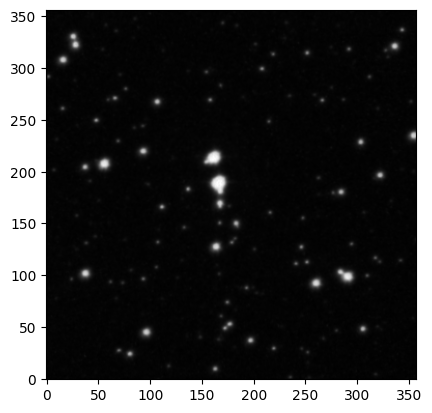

In [6]:
# plot it in a quick preview
plt.imshow(hdul_list[0].data, cmap="gray", origin="lower")

This should be done for every image in the list. However, downloading all the data takes quite some time. For this tutorial, **we prepared a subsample of 335 of these Short Red images that will run promptly** but we encourage you to try accessing the full Short Red sample on your own later. The subsample is available in the Data Folder of this repository.

## Step 2: Create a MOC of the MASH images

The multi-order coverage (MOC) map of a set of images represents their sky coverage. MOCs can describe arbitrary zones in the sky which do not need to be connected. You'll see that the union or intersection of two MOCs requires few time and computational effort. Catalogs can also be filtered by MOCs. 

Here we want to use the fits files just downloaded to create a MOC map corresponding to the coverage of the MASH images.

### Organising data

In [7]:
# Where to find fits images downloaded from the archive above
datadir = Path("Data/MASH_Sample/")
datadir.mkdir(parents=True, exist_ok=True)

In most cases, we could ignore the next cell.  However, some possible deprecated keywords in the fits header would hamper the MOC creation and would cause errors in the underlying `astropy.wcs.WCS` module. This is why we rewrite the headers of the fits files so that they only contain the useful keywords needed to define the coordinate frame correctly before using `mocpy`. 

### Create the MOC

Here we can create the MOC of the MASH images with the `MOCPy` module. This can take a few seconds.

In [8]:
# Get a list of the fits files and create the MOC
mash_file_list = datadir.glob(
    "*_sr_modified.fits",
)  # glob allows to find all paths that end with _sr_modified.fits in datadir
moc_mash = mocpy.MOC.from_fits_images(mash_file_list, max_norder=15)
# this takes a bit of time because a lot of files are opened and processed to extract the moc

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### Plot the MOC

We can chose between two of the MOCpy methods to plot the MOC

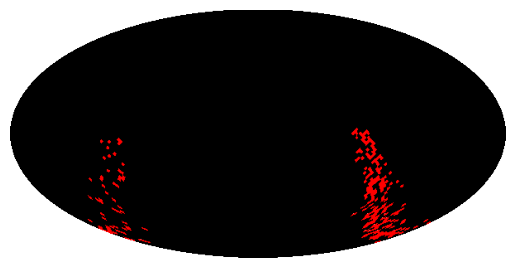

In [9]:
# A one-liner for a very fast visualization
moc_mash.display_preview()

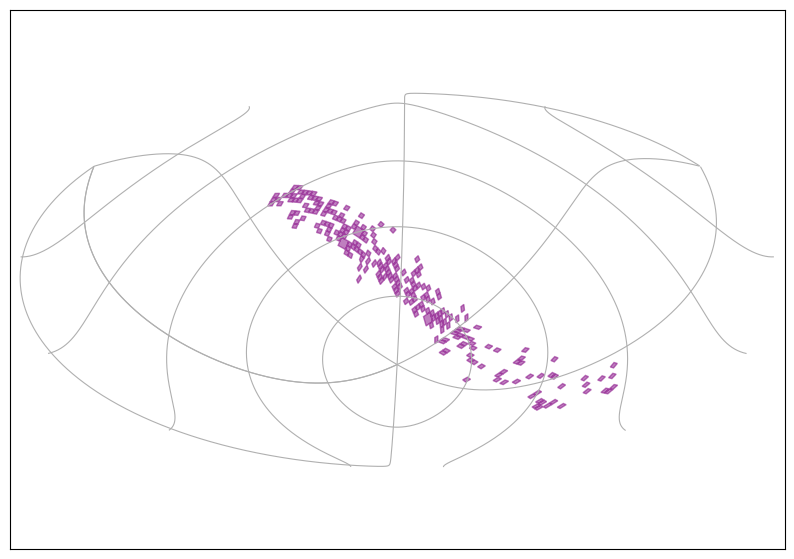

In [10]:
# With a bit more control over the output, the MOC.wcs method
fig = plt.figure(figsize=(10, 7))
wcs = moc_mash.wcs(fig)
ax = fig.add_subplot(projection=wcs)
ax.grid(True)  # noqa: FBT003
moc_mash.fill(ax, wcs, color="purple", alpha=0.5)

You can see how the MOC has arbitrary shapes and not all regions are connected.

And for more control over the plot parameters, there is also the mocpy.WCS method (!)

## Step 3: Load an archival extinction map and create the MOC of the low extinction regions

Different works (e.g. [Schlegel et al. 1998](https://iopscience.iop.org/article/10.1086/305772), [Schlafly  & Finkbeiner 2011](https://ui.adsabs.harvard.edu/abs/2011AAS...21831803S/abstract), [Green et al. 2015](https://iopscience.iop.org/article/10.1088/0004-637X/810/1/25)...) have created extinction maps of the sky that are publicly available. Some of these maps are all-sky maps, while others have higher resolutions, or come from different methods... They can be found in HEALPix format (among others) on the Legacy Archive for Microwave Background Data Analysis ([LAMBDA](https://lambda.gsfc.nasa.gov/)) website or on the Analysis Center for Extended Data ([CADE](http://cade.irap.omp.eu/dokuwiki/doku.php?id=start)) website. 

For this tutorial, we will download the well-known all-sky extinction map from Schlegel *et al.* from the LAMBDA  website and define the low extinction area for which $0 < E(B-V) < 0.5$ as a MOC. It has an [information page](https://lambda.gsfc.nasa.gov/product/foreground/fg_sfd_info.html).

The map is available here: https://lambda.gsfc.nasa.gov/data/foregrounds/SFD/lambda_sfd_ebv.fits and we save it to disc. 

In [11]:
hdul = fits.open(
    "https://lambda.gsfc.nasa.gov/data/foregrounds/SFD/lambda_sfd_ebv.fits",
)

We are only interested in regions with low extinction. So we aim to get a MOC of all regions where the extinction values from the Schlegel *et al.* map are between 0 and 0.5mag. The extinction map we got from the NASA webpage is in the HEALPix format. This is an efficient presentation of all-sky maps. The HEALPix tesselation is also used by MOCs. So to get the MOC from the extinction map, we do the following. 

First, we check the coordinate system in the map header. We will need to convert to equatorial coordinates, change the projection of the map, and set the order (*i.e.* resolution) of the map.

In [12]:
hdr = hdul[0].header
hdr

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2003-02-05T00:00:00' /file creation date (YYYY-MM-DDThh:mm:ss UT)    
OBJECT  = 'ALL-SKY '           / Portion of sky given                           
COMMENT   This file contains an all-sky Galactic reddening map, E(B-V), based on
COMMENT   the derived reddening maps of Schlegel, Finkbeiner and Davis (1998).  
COMMENT   Software and data files downloaded from their website were used to    
COMMENT   interpolate their high resolution dust maps onto pixel centers        
COMMENT   appropriate for a 

In [13]:
print((hdul[1].data).shape)
hdul[1].data

(3145728,)


FITS_rec([( 9.625492, 1.), (46.090515, 1.), ( 8.18071 , 1.), ...,
          (15.149189, 1.), (14.107367, 1.), (15.463686, 1.)],
         dtype=(numpy.record, [('TEMPERATURE', '>f4'), ('N_OBS', '>f4')]))

The data field here has a specific shape. It contains tuples for which the first value is the extinction (named 'TEMPERATURE') and the second one is the number of observations of the value (you can check that it is `1` everywhere).

In [14]:
extinction_values = hdul[1].data["TEMPERATURE"]

 Let's extract the information about the number of sides and the order of the healpix map from the header of the fits file

In [15]:
nside = hdul[0].header["NSIDE"]
norder = hdul[0].header["RESOLUTN"]

The header allows to see that this map is in galactic coordinates. We will need to convert this into equatorial coordinates to compare with our other maps.

In [16]:
# Creation of an HEALpix grid at order 9 in nested ordering
healpix_index = np.arange(12 * 4**norder, dtype=np.uint64)
print(
    f"We can check the the NPIX value corresponds to the one in the header here: {len(healpix_index)}",
)

We can check the the NPIX value corresponds to the one in the header here: 3145728


In [17]:
# Get the coordinates of the centers of these healpix cells
center_coordinates_in_equatorial = cdshealpix.healpix_to_skycoord(
    healpix_index,
    depth=9,
)
center_coordinates_in_equatorial

<SkyCoord (ICRS): (ra, dec) in deg
    [( 45.        ,  0.0746039 ), ( 45.08789062,  0.14920793),
     ( 44.91210938,  0.14920793), ..., (315.08789062, -0.14920793),
     (314.91210938, -0.14920793), (315.        , -0.0746039 )]>

In [18]:
# Convert this into galactic coordinates
center_coordinates_in_galactic = center_coordinates_in_equatorial.galactic
center_coordinates_in_galactic

<SkyCoord (Galactic): (l, b) in deg
    [(176.8796283 , -48.85086427), (176.89078038, -48.7358142 ),
     (176.70525363, -48.86216423), ..., ( 48.82487228, -28.4122831 ),
     ( 48.7216889 , -28.26178141), ( 48.84578935, -28.29847774)]>

In [19]:
# Calculate the bilinear interpolation we must apply to each healpix cell to get the values in the other coordinate system
healpix, weights = cdshealpix.bilinear_interpolation(
    center_coordinates_in_galactic.l,
    center_coordinates_in_galactic.b,
    depth=norder,
)

In [20]:
# Apply the interpolation
ext_map_equatorial_nested = (extinction_values[healpix.data] * weights.data).sum(axis=1)
ext_map_equatorial_nested

array([0.08981742, 0.0991632 , 0.08249644, ..., 0.08323811, 0.08352184,
       0.0820533 ])

Next we declare which pixel we want to use, let's take all pixels with an extinction lower than 0.5:

In [21]:
low_extinction_index = np.where(ext_map_equatorial_nested < 0.5)[0]
print(
    f"The low extinction criteria keeps {round((len(low_extinction_index)/ len(extinction_values)*100), 2)}% of the sky map",
)

The low extinction criteria keeps 86.74% of the sky map


And let's create a MOC from this criteria

In [22]:
moc_low_extinction = mocpy.MOC.from_healpix_cells(
    low_extinction_index,
    np.full(
        (
            len(
                low_extinction_index,
            )
        ),
        norder,
    ),
    norder,
)

## Step 4:  Find out which regions are covered by the MASH short-red images in the low extinction regions defined above

To find out the sky regions of the MASH sample that are at low extinction, we build the intersection of the two MOCs.

In [23]:
moc_intersection = moc_low_extinction.intersection(moc_mash)
# Once the intersection is bluit, we can for example print the sky fraction :
print(
    f"The intersection of the two MOCs covers {round(moc_intersection.sky_fraction * 100, 4)}% of the sky",
)

The intersection of the two MOCs covers 0.4778% of the sky


Now we can visualize the coverage of the two MOCs and their intersection. The grey area is where the extinction is low. The blue one is the MASH coverage. The tiny red dots show the MASH coverage in low extinction regions. 

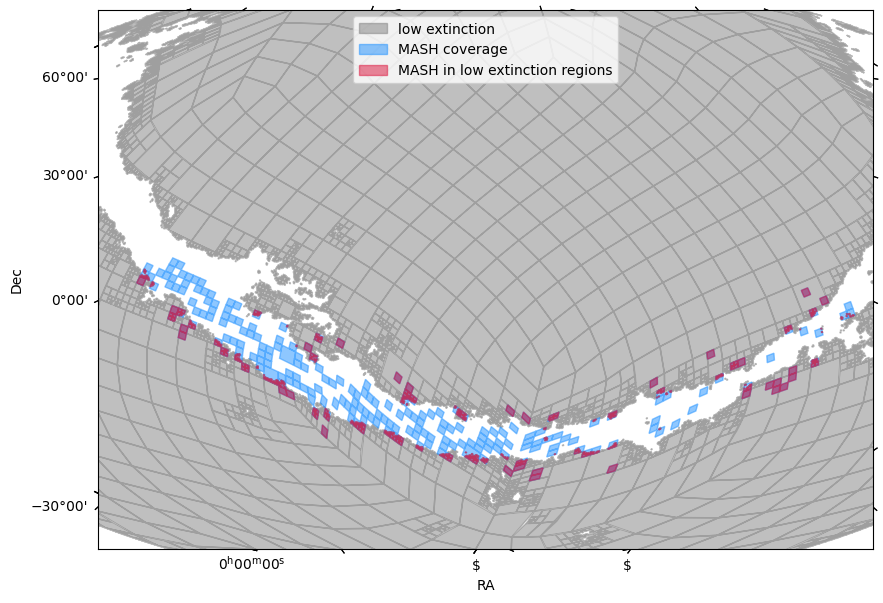

In [24]:
fig = plt.figure(111, figsize=(10, 7))

with mocpy.WCS(
    fig,
    fov=140 * u.deg,
    center=SkyCoord(200, -20, unit="deg", frame="icrs"),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    projection="AIT",
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs)

    moc_low_extinction.fill(
        ax=ax,
        wcs=wcs,
        alpha=0.5,
        fill=True,
        color="grey",
        label="low extinction",
    )
    moc_mash.fill(
        ax=ax,
        wcs=wcs,
        alpha=0.5,
        fill=True,
        color="dodgerblue",
        label="MASH coverage",
    )
    moc_intersection.fill(
        ax=ax,
        wcs=wcs,
        alpha=0.5,
        fill=True,
        color="crimson",
        label="MASH in low extinction regions",
    )
    # Sets labels
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    # Sets ticks
    lon, lat = ax.coords[0], ax.coords[1]
    lon.set_major_formatter("hh:mm:ss")
    lat.set_major_formatter("dd:mm")
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)
plt.legend()

## Step 5: Query the 2MASS and Gaia Catalogues by MOC

Without the usage of MOC, querying for sources in the low extinction regions covered by the MASH subsample would be tedious or even impossible. Indeed, one would need to load the whole catalog and make selections which would not be possible given the size of some catalogs. Alternatively, one would need to query the catalog field by field, which would take time and several queries. Instead, here we will use the power of MOC files to query large catalogs directly in the covered regions only. We will use coverages of the low extinction and MASH regions to query for sources from the Gaia and 2MASS surveys in these highly non-continuous and non-trivial shape areas.

First, let's see which Gaia and 2MASS catalogs are available on VizieR. We could, as above, use the TAP endpoint of VizieR. But we show below the `Vizier` module in the `astroquery` package.

In [25]:
catalog_list_twomass = Vizier.find_catalogs("Cutri")
for k, v in catalog_list_twomass.items():
    print(k, ": ", v.description)

J/ApJ/874/82 :  Follow-up photometry & spectroscopy of PTF14jg (Hillenbrand+, 2019)
II/241 :  2MASS Catalog Incremental Data Release (IPAC/UMass, 2000)
J/ApJ/569/23 :  Optical polarisation of 2MASS QSOs (Smith+, 2002)
II/246 :  2MASS All-Sky Catalog of Point Sources (Cutri+ 2003)
J/AJ/154/53 :  WISE/NEOWISE observations of comets (Bauer+, 2017)
J/ApJ/743/156 :  NEOWISE observations of NEOs: preliminary results (Mainzer+, 2011)
II/365 :  The CatWISE2020 catalog (updated version 28-Jan-2021) (Marocco+, 2021)
II/126 :  IRAS Serendipitous Survey Catalog (IPAC 1986)
J/AJ/112/62 :  Quasar absorption-line systems (Tanner+ 1996)
J/AJ/156/60 :  Thermal model fits for short-arc NEOs with NEOWISE (Masiero+, 2018)
J/ApJ/814/117 :  NEOWISE Reactivation mission: 1st yr data (Nugent+, 2015)
J/AJ/126/63 :  Host galaxies of 2MASS-QSOs with z<=3 (Hutchings+, 2003)
J/ApJ/742/40 :  Jovian Trojans asteroids with WISE/NEOWISE (Grav+, 2011)
II/311 :  WISE All-Sky Data Release (Cutri+ 2012)
J/ApJ/805/90 :  WI

In [26]:
catalog_list_gaia = Vizier.find_catalogs("Gaia DR2", max_catalogs=1000)
for k, v in catalog_list_gaia.items():
    print(k, ": ", v.description)

I/324 :  The Initial Gaia Source List (IGSL) (Smart, 2013)
I/337 :  Gaia DR1 (Gaia Collaboration, 2016)
I/345 :  Gaia DR2 (Gaia Collaboration, 2018)
I/347 :  Distances to 1.33 billion stars in Gaia DR2 (Bailer-Jones+, 2018)
I/350 :  Gaia EDR3 (Gaia Collaboration, 2020)
I/352 :  Distances to 1.47 billion stars in Gaia EDR3 (Bailer-Jones+, 2021)
I/355 :  Gaia DR3 Part 1. Main source (Gaia Collaboration, 2022)
I/356 :  Gaia DR3 Part 2. Extra-galactic (Gaia Collaboration, 2022)
I/357 :  Gaia DR3 Part 3. Non-single stars (Gaia Collaboration, 2022)
I/358 :  Gaia DR3 Part 4. Variability (Gaia Collaboration, 2022)
I/359 :  Gaia DR3 Part 5. Solar System (Gaia Collaboration, 2022)
I/360 :  Gaia DR3 Part 6. Performance verification (Gaia Collaboration, 2022)
I/361 :  Gaia Focused Product Release (Gaia FPR) (Gaia Collaboration, 2023)
IV/36 :  Gaia-IPHAS/KIS Value-Added Catalogues (Scaringi+, 2018)
VI/137 :  GaiaSimu Universe Model Snapshot (Robin+, 2012)
VI/145 :  ASC Gaia Attitude Star Catalog (S

For 2MASS we will want to use `II/246 :  2MASS All-Sky Catalog of Point Sources (Cutri+ 2003)` and for Gaia `I/345 :  Gaia DR2 (Gaia Collaboration, 2018)`. Before we query the full two tables we only look at a few sources for each table to understand which columns are available. The query below will give us 50 sources each -- the default for the `get_catalogs` method.

In [27]:
test_twomass = Vizier.get_catalogs("II/246")
print(test_twomass)
test_twomass[0]

TableList with 1 tables:
	'0:II/246/out' with 15 column(s) and 50 row(s) 


RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,
float64,float64,str17,float32,float32,float32,float32,float32,float32,str3,str3,str3,str3,uint8,uint8
44.996055,0.005565,02595905+0000200,16.376,0.097,15.770,0.140,15.258,0.141,ABB,222,111,000,0,0
45.004857,0.019806,03000116+0001113,12.529,0.024,11.954,0.030,11.874,0.029,AAA,222,111,000,0,0
45.004193,0.020956,03000100+0001154,14.845,0.056,14.223,0.077,14.016,0.055,AAA,222,111,ccc,0,0
44.995074,0.038204,02595881+0002175,16.746,0.134,15.814,0.140,16.125,0.324,BBD,222,111,000,0,0
44.963851,0.043587,02595132+0002369,16.476,0.113,16.057,0.175,15.564,--,BCU,220,110,000,0,0
45.048281,0.048329,03001158+0002539,13.354,0.025,12.874,0.030,12.699,0.030,AAA,222,111,000,0,0
45.023564,0.068472,03000565+0004064,14.729,0.038,14.141,0.043,14.024,0.074,AAA,222,111,000,0,0
44.993307,0.076423,02595839+0004351,14.921,0.036,14.557,0.063,14.472,0.081,AAA,222,111,000,0,0


In [28]:
test_gaia = Vizier.get_catalogs("I/345")
print(test_gaia)
test_gaia[0]

TableList with 20 tables:
	'0:I/345/gaia2' with 32 column(s) and 50 row(s) 
	'1:I/345/rvstdcat' with 30 column(s) and 50 row(s) 
	'2:I/345/rvstdmes' with 7 column(s) and 50 row(s) 
	'3:I/345/allwise' with 2 column(s) and 50 row(s) 
	'4:I/345/iers' with 2 column(s) and 50 row(s) 
	'5:I/345/cepheid' with 23 column(s) and 50 row(s) 
	'6:I/345/rrlyrae' with 21 column(s) and 50 row(s) 
	'7:I/345/lpv' with 11 column(s) and 50 row(s) 
	'8:I/345/varres' with 7 column(s) and 50 row(s) 
	'9:I/345/shortts' with 9 column(s) and 50 row(s) 
	'10:I/345/tsstat' with 13 column(s) and 50 row(s) 
	'11:I/345/numtrans' with 4 column(s) and 50 row(s) 
	'12:I/345/transits' with 20 column(s) and 50 row(s) 
	'13:I/345/rm' with 9 column(s) and 50 row(s) 
	'14:I/345/rmseg' with 16 column(s) and 50 row(s) 
	'15:I/345/rmout' with 2 column(s) and 50 row(s) 
	'16:I/345/ssoobj' with 6 column(s) and 50 row(s) 
	'17:I/345/ssoorb' with 19 column(s) and 50 row(s) 
	'18:I/345/ssores' with 10 column(s) and 50 row(s) 
	'19:

RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,mag,,,mag,mag,,,mag,mag,mag,km / s,km / s,K,mag,mag,solRad,solLum
float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
45.09385125633,0.5468,0.64718689957,0.5908,59236189231232,0.6518,0.6371,0.314,1.301,-0.696,1.185,0,216,1.702,19.8521,0.0086,139.7,26.32,19.9881,0.2045,180.2,9.54,19.1227,0.0575,0.8654,--,--,--,--,--,--,--
45.09016634680,0.1233,0.64778425962,0.1282,59236189231360,3.3237,0.1433,30.321,0.268,11.596,0.258,0,1668,2.888,17.6330,0.0019,334,12.01,19.0420,0.0390,2092,11.22,16.4604,0.0058,2.5817,--,--,--,--,--,--,--
45.09637402450,0.1503,0.65057829283,0.1729,59270548970752,0.1847,0.1751,3.537,0.324,0.654,0.329,0,1152,2.626,18.0343,0.0025,578.5,8.796,18.4457,0.0165,812.5,10.04,17.4873,0.0134,0.9584,--,--,--,--,--,--,--
45.10917067997,0.0508,0.65253074863,0.0511,59270548971648,3.0466,0.0589,-9.468,0.112,-42.970,0.108,0,8026,7.941,15.9271,0.0011,2279,19.84,16.9569,0.0094,8598,28.17,14.9259,0.0036,2.0310,--,--,3968.25,0.5188,0.2743,0.51,0.058
45.09796814525,0.1832,0.65754124036,0.2085,59270548972672,2.4526,0.2132,-5.853,0.398,-16.305,0.397,0,916.7,2.068,18.2828,0.0024,192.4,21.36,19.6409,0.1205,1180,9.902,17.0824,0.0091,2.5585,--,--,--,--,--,--,--
45.19007365441,0.1721,0.61029286301,0.1585,59407987910400,0.5127,0.2013,4.836,0.396,-7.668,0.343,0,796.5,2.06,18.4355,0.0028,316.2,12.3,19.1014,0.0422,697.3,19.29,17.6534,0.0300,1.4480,--,--,--,--,--,--,--
45.17954669668,0.0417,0.62334168746,0.0374,59481002873984,0.3591,0.0483,5.397,0.090,-2.072,0.079,0,1.06e+04,7.983,15.6254,0.0008,5177,21.25,16.0661,0.0045,7884,16.63,15.0201,0.0023,1.0461,--,--,5230.15,--,--,2.26,3.434
45.19835624575,0.7170,0.61889600019,0.6358,59511067349888,1.2027,0.8248,18.321,1.612,-5.007,1.486,0,158.9,1.178,20.1853,0.0080,32.06,9.529,21.5865,0.3227,194.4,14.25,19.0402,0.0796,2.5463,--,--,--,--,--,--,--


As you will see below, we only need coordinates, 2MASS photometry in the H and K band, and Gaia photometry in the Gaia G band. So we'll query the tables `II/246/out` for 2MASS and `I/345/gaia2` for Gaia DR2:

In [29]:
twomass = moc_intersection.query_vizier_table("II/246/out", max_rows=20000)
twomass

_2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD
,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,,,,d
str17,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,str3,int16,uint8,float64
06561231-2715514,104.051312,-27.264296,0.11,0.11,45.0,15.816,15.533,15.274,0.068,0.104,0.192,AAC,222,0,2451203.5942
06561317-2715210,104.05491,-27.255844,0.06,0.06,90.0,13.891,13.292,13.059,0.026,0.033,0.034,AAA,222,0,2451203.5942
06561481-2716053,104.061712,-27.268162,0.06,0.06,90.0,13.857,13.336,13.2,0.026,0.022,0.039,AAA,222,0,2451203.5942
06561479-2715417,104.061646,-27.261585,0.06,0.06,90.0,13.43,13.234,13.266,0.023,0.022,0.041,AAA,222,0,2451203.5942
06561641-2715166,104.068408,-27.254629,0.06,0.06,45.0,13.843,13.625,13.543,0.029,0.038,0.045,AAA,222,0,2451203.5942
06561656-2715126,104.069033,-27.253527,0.16,0.15,75.0,14.947,15.883,14.747,--,0.137,--,UBU,20,0,2451203.5942
06561660-2715246,104.069205,-27.256844,0.06,0.06,90.0,15.04,14.631,14.457,0.052,0.068,0.092,AAA,222,0,2451203.5942
06561532-2714537,104.063862,-27.248253,0.08,0.08,135.0,15.698,15.2,15.02,0.053,0.07,0.143,AAB,222,0,2451203.5942


In [30]:
gaia = moc_intersection.query_vizier_table("I/345/gaia2", max_rows=20000)
gaia

ra_epoch2000,dec_epoch2000,errHalfMaj,errHalfMin,errPosAng,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,duplicated_source,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,bp_rp,radial_velocity,radial_velocity_error,rv_nb_transits,teff_val,a_g_val,e_bp_min_rp_val,radius_val,lum_val
deg,deg,arcsec,arcsec,deg,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,e-/s,e-/s,mag,e-/s,e-/s,mag,e-/s,e-/s,mag,mag,km / s,km / s,,K,mag,mag,Rsun,Lsun
float64,float64,float32,float32,float32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float32,float32,float64,float64
104.0642397349738,-27.2482245363508,0.009,0.002,0.0,2920584465727934848,104.06423973497,2.314,-27.24822453635,8.5789,--,--,--,--,--,--,False,80.4691,1.21343,20.924294,--,--,--,--,--,--,--,--,--,0,--,--,--,--,--
104.0613350962615,-27.2457120515062,0.02,0.017,0.0,2920584465727934720,104.06133865504,0.4795,-27.24572610529,0.7266,2.7925,0.9319,0.735,1.066,-3.264,1.314,False,110.232,0.811783,20.582594,29.761,6.19097,21.667269,127.117,5.50348,19.50141,2.165859,--,--,0,--,--,--,--,--
104.0616994142013,-27.268162501078,0.001,0.001,0.0,2920584362651704192,104.06176472191,0.0195,-27.26826983064,0.0282,1.5899,0.0331,13.483,0.044,-24.928,0.058,False,12121.4,4.76419,15.479486,5099.4,12.5228,16.08259,10058.7,14.8426,14.755564,1.327026,--,--,0,4984.0,0.309,0.1495,0.61,0.21
104.0638238272635,-27.2482586806547,0.002,0.002,0.0,2920584461429778816,104.06382329382,0.0521,-27.24823315928,0.0765,0.6544,0.0872,-0.11,0.121,5.928,0.159,False,2056.52,1.79544,17.405537,875.686,6.96038,17.995518,1741.36,7.67767,16.659698,1.335819,--,--,0,--,--,--,--,--
104.0534300495002,-27.2500426156094,0.014,0.011,0.0,2920584427070040064,104.05342677462,0.3271,-27.25003658704,0.5302,0.8947,0.6557,-0.676,0.732,1.4,0.92,False,162.774,0.812274,20.159405,93.9469,11.4891,20.419182,132.283,6.62032,19.458162,0.96102,--,--,0,--,--,--,--,--
104.0751267092824,-27.2497140040521,0.007,0.006,0.0,2920584392710301952,104.07512382264,0.1708,-27.24969690641,0.2387,-0.2191,0.2883,-0.596,0.38,3.971,0.463,False,354.083,0.968096,19.315603,194.984,4.1286,19.626392,251.52,5.09448,18.760487,0.865906,--,--,0,--,--,--,--,--
104.0742449208677,-27.2644027644464,0.009,0.008,0.0,2920584392710299648,104.07423733605,0.2424,-27.26439208515,0.3022,0.1011,0.3706,-1.566,0.531,2.48,0.558,False,249.17,0.921325,19.697124,112.126,4.99648,20.227123,190.76,5.88838,19.060701,1.166422,--,--,0,--,--,--,--,--
104.0773944731844,-27.2633504544413,0.008,0.007,0.0,2920584392710299520,104.07739347867,0.2151,-27.26333600118,0.2962,-0.3964,0.3634,-0.205,0.474,3.357,0.546,False,270.933,0.898977,19.60621,116.801,5.97621,20.18277,216.387,5.2083,18.923845,1.258925,--,--,0,--,--,--,--,--


## Step 6: Cross-match Gaia and 2MASS sources in all fields

We now want to find sources in the selected region (observed in the MASH regions of interest and at low extinction) that are common to the 2MASS and Gaia catalogs. To do so, we will perform a cross-match of the Gaia and 2MASS catalogs. Alternatively, we could use the CDS XMatch service via the corresponding `astroquery` module.

To do so, let's first inspect the `match_coordinates_sky` function from `astropy.coordinates`. 

In [31]:
help(match_coordinates_sky)

Help on function match_coordinates_sky in module astropy.coordinates.matching:

match_coordinates_sky(matchcoord, catalogcoord, nthneighbor=1, storekdtree='kdtree_sky')
    Finds the nearest on-sky matches of a coordinate or coordinates in
    a set of catalog coordinates.
    
    This finds the on-sky closest neighbor, which is only different from the
    3-dimensional match if ``distance`` is set in either ``matchcoord``
    or ``catalogcoord``.
    
    Parameters
    ----------
    matchcoord : `~astropy.coordinates.BaseCoordinateFrame` or `~astropy.coordinates.SkyCoord`
        The coordinate(s) to match to the catalog.
    catalogcoord : `~astropy.coordinates.BaseCoordinateFrame` or `~astropy.coordinates.SkyCoord`
        The base catalog in which to search for matches. Typically this will
        be a coordinate object that is an array (i.e.,
        ``catalogcoord.isscalar == False``)
    nthneighbor : int, optional
        Which closest neighbor to search for.  Typically ``1`

In [32]:
# We generate the coordinates in the appropriate format
twomass_coord = SkyCoord(ra=twomass["RAJ2000"], dec=twomass["DEJ2000"], unit=u.deg)
gaia_coord = SkyCoord(ra=gaia["ra_epoch2000"], dec=gaia["dec_epoch2000"], unit=u.deg)

index, separation_2d, _ = match_coordinates_sky(twomass_coord, gaia_coord)

In [33]:
# Decide the maximum separation between objects to be considered acceptable matches
max_separation = 1.0 * u.arcsec
# Apply constraint on the two catalogs
sep_constraint = separation_2d < max_separation
twomass_matches = twomass[sep_constraint]
gaia_matches = gaia[index[sep_constraint]]
# Select only interesting columns from twomass_matches
match_catalog = twomass_matches["_2MASS", "RAJ2000", "DEJ2000", "Hmag", "Kmag"]
# Add column G magnitude from gaia
match_catalog["Gmag"] = gaia_matches["phot_g_mean_mag"]
match_catalog

_2MASS,RAJ2000,DEJ2000,Hmag,Kmag,Gmag
,deg,deg,mag,mag,mag
str17,float64,float64,float32,float32,float64
06561231-2715514,104.051312,-27.264296,15.533,15.274,16.924894
06561317-2715210,104.05491,-27.255844,13.292,13.059,16.701544
06561481-2716053,104.061712,-27.268162,13.336,13.2,15.479486
06561479-2715417,104.061646,-27.261585,13.234,13.266,14.229291
06561641-2715166,104.068408,-27.254629,13.625,13.543,14.883485
06561656-2715126,104.069033,-27.253527,15.883,14.747,18.727604
06561660-2715246,104.069205,-27.256844,14.631,14.457,16.435612
06561532-2714537,104.063862,-27.248253,15.2,15.02,17.405537


## Step 7: Build a color-color diagram

We now use the data we got from the cross-match to get a 2MASS/Gaia color-color diagram for all the sources in the low extinction sky regions covered by the MASH survey:

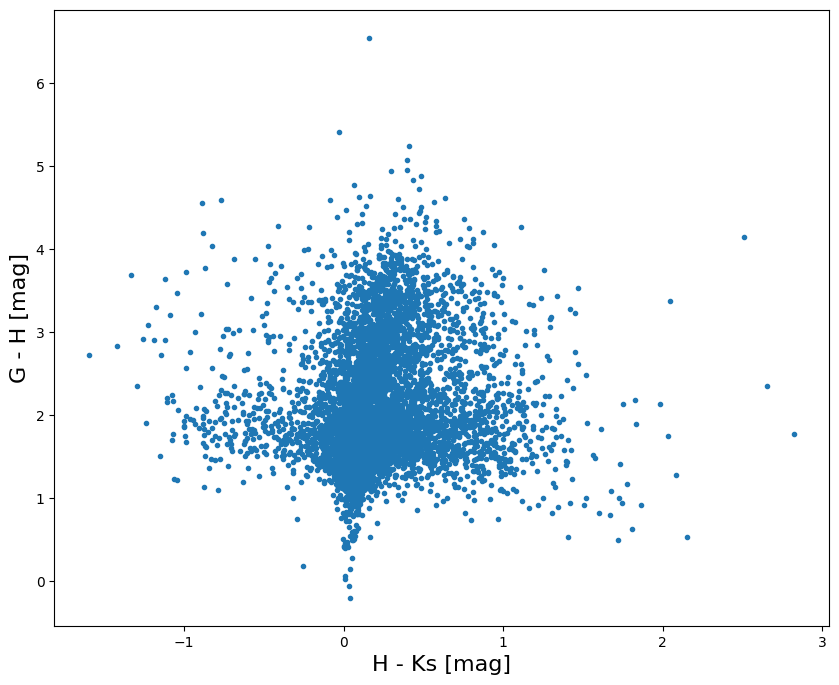

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(
    match_catalog["Hmag"] - match_catalog["Kmag"],
    match_catalog["Gmag"] - match_catalog["Hmag"],
    linestyle="",
    marker=".",
)
ax.set_xlabel("H - Ks [mag]", fontsize=16)
ax.set_ylabel("G - H [mag]", fontsize=16)
plt.show()